In [2]:
!pip install web3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 4.24.4 which is incompatible.


  Using cached cached_property-1.5.2-py2.py3-none-any.whl (7.6 kB)
  Using cached jsonschema-4.17.3-py3-none-any.whl (90 kB)
  Using cached protobuf-4.24.4-cp37-cp37m-win_amd64.whl (430 kB)
  Created wheel for parsimonious: filename=parsimonious-0.9.0-py3-none-any.whl size=44301 sha256=a8b6b85c171991d938e9bfa9aad83188f1c6ad4ba37d8f2e4779c1562b7902ec
  Stored in directory: c:\users\nexus computers\appdata\local\pip\cache\wheels\a4\54\88\c1ee7de0eabd1fb817cbf35824e4c2cba664d5816ddc64efb1
Successfully built parsimonious
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 3.2.0
    Uninstalling jsonschema-3.2.0:
      Successfully uninstalled jsonschema-3.2.0


In [3]:
import os
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from web3 import Web3

In [9]:
# --- Blockchain Setup ---
# Connect to local Ganache blockchain
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:7545"))
assert w3.is_connected(), "Blockchain connection failed"
print("Connected to Ganache:", w3.is_connected())

Connected to Ganache: True


In [22]:
# Set your deployed contract address and ABI here
contract_address = "0x3858dab8be5218d3a433a536ab6df1b7cfc029db"  # REPLACE with your contract address
abi =[
        {
            "inputs": [],
            "name": "claimReward",
            "outputs": [],
            "stateMutability": "nonpayable",
            "type": "function"
        },
        {
            "inputs": [],
            "stateMutability": "nonpayable",
            "type": "constructor"
        },
        {
            "anonymous": False,
            "inputs": [
                {
                    "indexed": True,
                    "internalType": "address",
                    "name": "participant",
                    "type": "address"
                }
            ],
            "name": "ConsentGiven",
            "type": "event"
        },
        {
            "anonymous": False,
            "inputs": [
                {
                    "indexed": True,
                    "internalType": "address",
                    "name": "participant",
                    "type": "address"
                }
            ],
            "name": "ConsentRevoked",
            "type": "event"
        },
        {
            "inputs": [],
            "name": "depositRewardPool",
            "outputs": [],
            "stateMutability": "payable",
            "type": "function"
        },
        {
            "inputs": [],
            "name": "distributeRewards",
            "outputs": [],
            "stateMutability": "nonpayable",
            "type": "function"
        },
        {
            "inputs": [],
            "name": "giveConsent",
            "outputs": [],
            "stateMutability": "nonpayable",
            "type": "function"
        },
        {
            "inputs": [],
            "name": "revokeConsent",
            "outputs": [],
            "stateMutability": "nonpayable",
            "type": "function"
        },
        {
            "anonymous": False,
            "inputs": [
                {
                    "indexed": True,
                    "internalType": "address",
                    "name": "participant",
                    "type": "address"
                },
                {
                    "indexed": False,
                    "internalType": "uint256",
                    "name": "amount",
                    "type": "uint256"
                }
            ],
            "name": "RewardClaimed",
            "type": "event"
        },
        {
            "anonymous": False,
            "inputs": [
                {
                    "indexed": False,
                    "internalType": "uint256",
                    "name": "totalRewardPool",
                    "type": "uint256"
                }
            ],
            "name": "RewardsDistributed",
            "type": "event"
        },
        {
            "inputs": [
                {
                    "internalType": "uint256",
                    "name": "score",
                    "type": "uint256"
                }
            ],
            "name": "submitUpdate",
            "outputs": [],
            "stateMutability": "nonpayable",
            "type": "function"
        },
        {
            "anonymous": False,
            "inputs": [
                {
                    "indexed": True,
                    "internalType": "address",
                    "name": "participant",
                    "type": "address"
                },
                {
                    "indexed": False,
                    "internalType": "uint256",
                    "name": "score",
                    "type": "uint256"
                }
            ],
            "name": "UpdateSubmitted",
            "type": "event"
        },
        {
            "inputs": [],
            "name": "owner",
            "outputs": [
                {
                    "internalType": "address",
                    "name": "",
                    "type": "address"
                }
            ],
            "stateMutability": "view",
            "type": "function"
        },
        {
            "inputs": [
                {
                    "internalType": "uint256",
                    "name": "",
                    "type": "uint256"
                }
            ],
            "name": "participantAddresses",
            "outputs": [
                {
                    "internalType": "address",
                    "name": "",
                    "type": "address"
                }
            ],
            "stateMutability": "view",
            "type": "function"
        },
        {
            "inputs": [
                {
                    "internalType": "address",
                    "name": "",
                    "type": "address"
                }
            ],
            "name": "participants",
            "outputs": [
                {
                    "internalType": "bool",
                    "name": "consentGiven",
                    "type": "bool"
                },
                {
                    "internalType": "uint256",
                    "name": "contributionScore",
                    "type": "uint256"
                },
                {
                    "internalType": "uint256",
                    "name": "reward",
                    "type": "uint256"
                },
                {
                    "internalType": "bool",
                    "name": "exists",
                    "type": "bool"
                }
            ],
            "stateMutability": "view",
            "type": "function"
        },
        {
            "inputs": [],
            "name": "totalContributionScore",
            "outputs": [
                {
                    "internalType": "uint256",
                    "name": "",
                    "type": "uint256"
                }
            ],
            "stateMutability": "view",
            "type": "function"
        },
        {
            "inputs": [],
            "name": "totalRewardPool",
            "outputs": [
                {
                    "internalType": "uint256",
                    "name": "",
                    "type": "uint256"
                }
            ],
            "stateMutability": "view",
            "type": "function"
        }
    ]




In [28]:
# Convert it to checksum format
checksum_address = w3.to_checksum_address(contract_address)


# Create the contract object
contract = w3.eth.contract(address=checksum_address, abi=abi)
# Example usage: print the contract address to confirm
print("Contract checksum address:", contract.address)

# Use Ganache accounts (assumes accounts are unlocked)
owner_account = w3.eth.accounts[0]
client_accounts = w3.eth.accounts[1:6]  # Five client accounts

Contract checksum address: 0x3858DAb8Be5218D3a433A536ab6df1b7cFc029db


In [12]:
# --- Federated Learning Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Define dataset paths and transforms (update paths as necessary)
base_dir = 'Blockchain_Secured_Federated_Learning\chest_xray\chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [15]:
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        image, label = dataset[i]
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


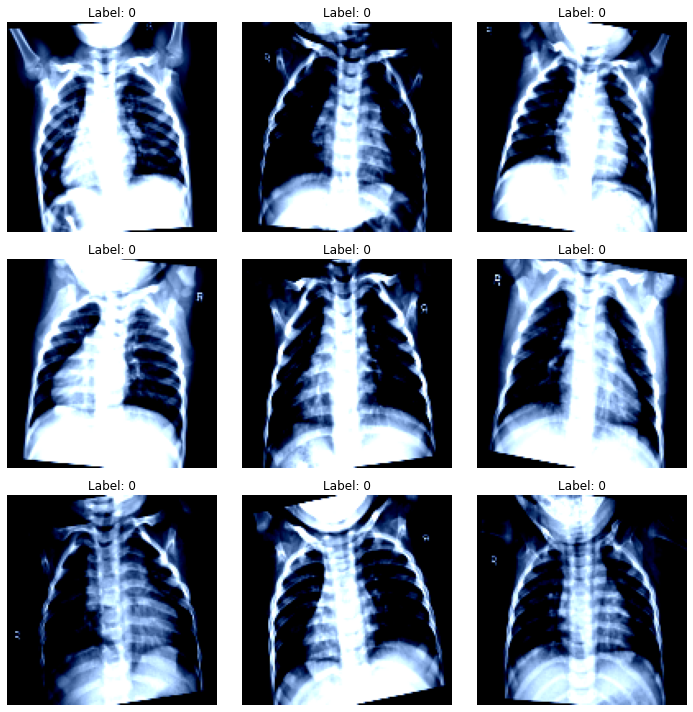

In [16]:
visualize_images(train_dataset)

In [17]:
# Define the model architecture using MobileNet V2
def create_model():
    model = models.mobilenet_v2(pretrained=True)
    model.features[18] = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(1280)
    )
    model.classifier[1] = nn.Linear(model.last_channel, 1)
    return model

global_model = create_model().to(device)
criterion = nn.BCEWithLogitsLoss()

C:\Users\NEXUS COMPUTERS\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\NEXUS COMPUTERS\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\NEXUS COMPUTERS/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [18]:
# Federated averaging: aggregates local models
def federated_averaging(models_list):
    global_model = copy.deepcopy(models_list[0])
    with torch.no_grad():
        for key in global_model.state_dict().keys():
            tensors = [model.state_dict()[key].data.float() for model in models_list]
            global_model.state_dict()[key].data.copy_(torch.mean(torch.stack(tensors), dim=0))
    return global_model

In [19]:
# Split dataset into subsets for each client
def split_dataset(dataset, num_clients):
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, num_clients)
    return [Subset(dataset, idx) for idx in split_indices]

num_clients = 5
client_datasets = split_dataset(train_dataset, num_clients)
client_dataloaders = [DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in client_datasets]

# Initialize client models as copies of the global model
client_models = [copy.deepcopy(global_model) for _ in range(num_clients)]

In [34]:
# --- Smart Contract Interaction: Consent ---
# Each client gives consent by calling the contract's giveConsent() function.
for i, client_account in enumerate(client_accounts):
    try:
        tx_hash = contract.functions.giveConsent().transact({'from': client_account})
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Client {i+1} consent given: {receipt.transactionHash.hex()}")
    except Exception as e:
        print(f"Client {i+1}: Consent already given or error occurred: {e}")

Client 1: Consent already given or error occurred: ('execution reverted: VM Exception while processing transaction: revert Consent already given', {'hash': None, 'programCounter': 1648, 'result': '0x08c379a000000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000015436f6e73656e7420616c726561647920676976656e0000000000000000000000', 'reason': 'Consent already given', 'message': 'revert'})
Client 2: Consent already given or error occurred: ('execution reverted: VM Exception while processing transaction: revert Consent already given', {'hash': None, 'programCounter': 1648, 'result': '0x08c379a000000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000015436f6e73656e7420616c726561647920676976656e0000000000000000000000', 'reason': 'Consent already given', 'message': 'revert'})
Client 3: Consent already given or error occurred: ('execution reverted: VM Except

In [35]:
# --- Training and Contract Submission ---
def train_model(model, dataloader, criterion, optimizer, epochs=1):
    model.train()
    running_loss = 0.0
    for _ in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    return model, avg_loss

In [37]:
# Run federated training over multiple rounds
num_rounds = 10
client_update_scores = [0] * num_clients  # To accumulate each client's performance score

for round_num in range(num_rounds):
    print(f"Round {round_num+1}/{num_rounds}")
    # Each client trains on its local data and submits an update score
    for i, (client_model, dataloader, client_account) in enumerate(zip(client_models, client_dataloaders, client_accounts)):
        optimizer = optim.Adam(client_model.parameters(), lr=0.001)
        client_model, train_loss = train_model(client_model, dataloader, criterion, optimizer)
        # Using inverse of training loss as a performance metric (higher is better)
        performance_score = 1 / (train_loss + 1e-5)
        client_update_scores[i] += performance_score
        
        # Scale score to an integer (e.g., multiply by 1e6)
        scaled_score = int(performance_score * 1e6)
        tx_hash = contract.functions.submitUpdate(scaled_score).transact({'from': client_account})
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Client {i+1} update submitted with score {performance_score:.4f}: {receipt.transactionHash.hex()}")
    
    # Aggregate client models using federated averaging
    global_model = federated_averaging(client_models)
    # Distribute the updated global model to all clients
    for client_model in client_models:
        client_model.load_state_dict(global_model.state_dict())

Round 1/10
Client 1 update submitted with score 5.2730: 0xf79f3209ab7700aaa68076fe0cb2e43bc72ea116f80b9b67ee40581cde61efb9
Client 2 update submitted with score 3.3629: 0x7c137df7a39526bf2e3b9e29484150e97c94284b9d6e2fbef161fddda19612ca
Client 3 update submitted with score 3.7670: 0x8aa14b49a952f067e403769b1e2b9c55641c4c3371e4652574694f2ad4c25eda
Client 4 update submitted with score 3.6795: 0x45d6af8b5df5a2b79ac0fe1601a5268c6a16294f38dd9fedf2f2554f8c20d1fb
Client 5 update submitted with score 3.8764: 0x5434f526def12013aa326dc4dd773fd7889e1b29594bc98f4e4760afb1ba3301
Round 2/10
Client 1 update submitted with score 4.5990: 0x89326f197e1b00cda7ceafc3f48957a76b372eced0ade3dacad937203ea92731
Client 2 update submitted with score 6.8180: 0x77adebd2757be95055569089f6b68595e5a55352bfec71b71d2e15741a08d6be
Client 3 update submitted with score 4.2051: 0x4c668e305ce8318406e36543255d7123a751a5c4e7d9105e81c5bc12dbe1da1d
Client 4 update submitted with score 6.9338: 0x95974bf50dff51562f2dcc3068c903b9a2c

In [39]:
# --- Reward Distribution ---
# Owner deposits reward pool (e.g., 1 Ether) into the contract
tx_hash = contract.functions.depositRewardPool().transact({
    'from': owner_account,
    'value': Web3.to_wei(1, 'ether')
})
receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
print("Reward pool deposited:", receipt.transactionHash.hex())

# Owner calls distributeRewards() to allocate rewards based on contributions
tx_hash = contract.functions.distributeRewards().transact({'from': owner_account})
receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
print("Rewards distributed:", receipt.transactionHash.hex())

Reward pool deposited: 0x9a8eda59ef5bde4afebc613adb74c7c48aa019adbcc3ee2eac2494415c3a841a
Rewards distributed: 0xa63ede5a3e93c6f03b4f6e6217f5151a666ad3c2b59c06a22340d4b5c975bb06


In [40]:
# --- Evaluation ---
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)
    return correct / total

In [41]:
accuracy = evaluate_model(global_model, val_loader)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 56.25%


In [42]:
# --- Clients Claim Rewards ---
for i, client_account in enumerate(client_accounts):
    tx_hash = contract.functions.claimReward().transact({'from': client_account})
    receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"Client {i+1} claimed reward: {receipt.transactionHash.hex()}")

Client 1 claimed reward: 0x0e196275ecbe1c1cb6c74c7af7aa89d5db0d2cdf88f5f4a2a810e6423e2146c4
Client 2 claimed reward: 0x426bfbaf93d2abed8fab55bf2c406fd38af8f12164b45434810c19f7fc0af449
Client 3 claimed reward: 0xa9ba314eb719e51643ada5100a891986a39b023a71c19eddc9cb422a96b6f7ea
Client 4 claimed reward: 0xe8e410de8c4e6d8e38bd5885cb9ac68b043b12250ef6353149d23d113cda3e3d
Client 5 claimed reward: 0xada7216f90fd77c8892d1f3115b910b12aa00bc09f46aefeff7aef3e36e4b8e0
